![](img/330-banner.png)

# Lecture 14: Clustering 

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import os
import random
import sys
import time

import numpy as np

sys.path.append("code/.")
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from plotting_functions import *
from plotting_functions_unsup import *
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

plt.style.use("seaborn")

%matplotlib inline

## Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:

- Explain the motivation and potential applications of clustering. 
- Define the clustering problem. 
- Explain the K-Means algorithm.  
- Apply `sklearn`'s `KMeans` algorithm.  
- Apply the Elbow method and Silhouette method to choose the number of clusters. 
- Use clustering for customer segmentation problem. 
- Interpret the clusters discovered by K-Means. 

## Unsupervised learning 

### Types of machine learning from 

Recall the typical learning problems we discussed at the beginning of the course. 

- Supervised learning ([Gmail spam filtering](https://support.google.com/a/answer/2368132?hl=en))
    - Training a model from input data and its corresponding targets to predict targets for new examples. (571, 572, 573)    
- **Unsupervised learning** (this course) ([Google News](https://news.google.com/))
    - Training a model to find patterns in a dataset, typically an unlabeled dataset.
- Reinforcement learning ([AlphaGo](https://deepmind.com/research/case-studies/alphago-the-story-so-far))
    - A family of algorithms for finding suitable actions to take in a given situation in order to maximize a reward. 
- **Recommendation systems** ([Amazon item recommendation system](https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf))
    - Predict the "rating" or "preference" a user would give to an item.    

### Supervised learning

- Training data comprises a set of observations ($X$) and their corresponding targets ($y$). 
- We wish to find a model function $f$ that relates $X$ to $y$.
- Then use that model function to predict the targets of new examples.
- We have been working with this set up so far. 

<img src="img/sup-learning.png" height="1000" width="1000"> 

### Labeled vs. Unlabeled data
- If you have access to labeled training data, you're in the "supervised" setting. 
- You know what to do in that case. 
- Unfortunately, getting large amount of labeled training data is often difficult, expensive, or simply impossible in some cases. 
- Can you still make sense of the data even though you do not have the labels? 
- Yes! At least to a certain extent! 

### Unsupervised learning

- Training data consists of observations ($X$) without any corresponding targets.
- Unsupervised learning could be used to group similar things together in $X$. 

<img src="img/unsup-learning.png" alt="" height="900" width="900"> 

### Example: Supervised vs unsupervised learning

- In supervised learning, we are given features $X$ and target $y$. 


<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> 101.0
                <td> Sick
            </tr>
            <tr>
                <td> 98.5 
                <td> Not Sick
            </tr>
            <tr>
                <td> 93.8 
                <td> Sick
            </tr>
            <tr>
                <td> 104.3
                <td> Sick
            </tr>
            <tr>
                <td> 98.6 
                <td> Not Sick
            </tr>
        </table>
    </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32 
                <td>class 1
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
                <td> class 1
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
                <td> class 2
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
                <td> class 2
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28 
                <td> class 3
            </tr>
        </table>
    </td>
</tr>
</table>

- In unsupervised learning, we are only given features $X$. 

<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
            </tr>
            <tr>
                <td> 101.0
            </tr>
            <tr>
                <td> 98.5 
            </tr>
            <tr>
                <td> 93.8 
            </tr>
            <tr>
                <td> 104.3
            </tr>
            <tr>
                <td> 98.6 
            </tr>
        </table>
    </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset 2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32 
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28 
            </tr>
        </table>
    </td>
</tr>
</table>

### An example with `sklearn` toy dataset

In [2]:
## Iris dataset
iris = datasets.load_iris()  # loading the iris dataset
features = iris.data[:, 2:4]  # only consider two features for visualization
labels = iris.target_names[
    iris.target
]  # get the targets, in this case the types of the Iris flower

iris_df = pd.DataFrame(features, columns=iris.feature_names[2:])
iris_df.head()

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


In [3]:
np.unique(labels)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

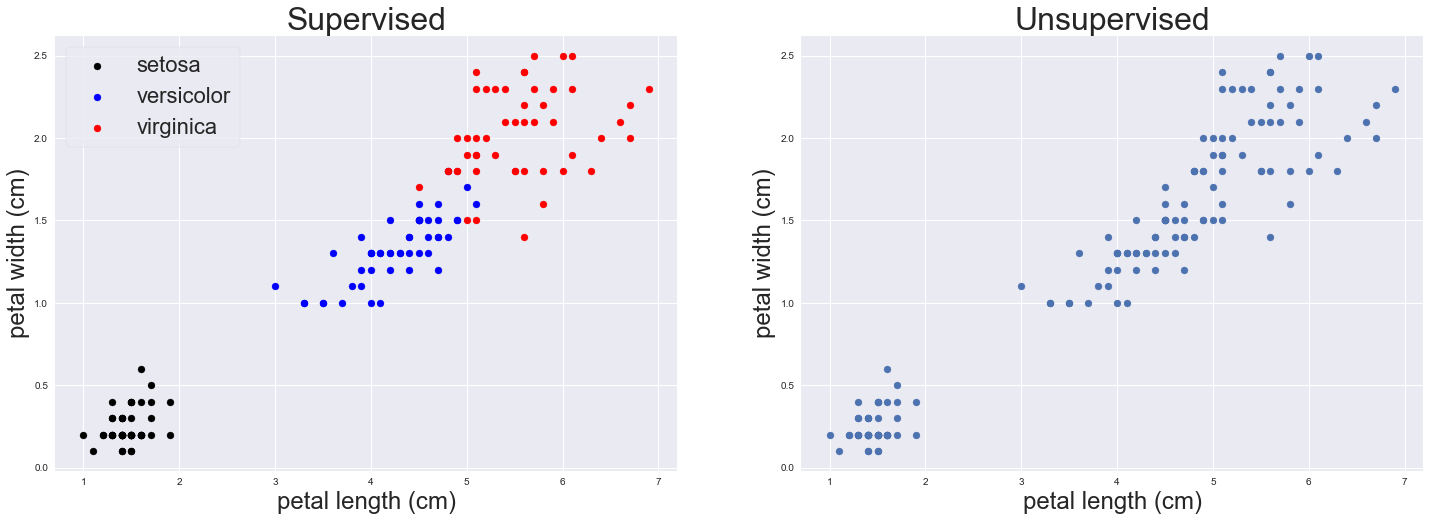

In [4]:
iris_df["target"] = labels
plot_sup_x_unsup(iris_df, 8, 8)

- In case of supervised learning, we're given $X$ and $y$ (showed with different colours in the plot above). 
- In case of unsupervised learning, we're only given $X$ and the goal is to identify the underlying structure in data.  

### Can we learn without targets?

- Yes, but the learning will be focused on finding the underlying structures of the inputs themselves (rather than finding the function $f$ between input and output like we did in supervised learning models). 

- Examples:
    - Clustering
    - Dimensionality Reduction (we won't cover it in this course)

<br><br>

## Clustering motivation 

### Why clustering? 

- Most of the data out there is unlabeled.  
- Getting labeled training data is often difficult, expensive, or simply impossible in some cases. 
- Can we extract some useful information from unlabeled data? 
- The most intuitive way is to group similar examples together to get some insight into the data even though we do not have the targets.  

### Clustering  

**Clustering** is the task of partitioning the dataset into groups called clusters.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.          

### Input and possible output

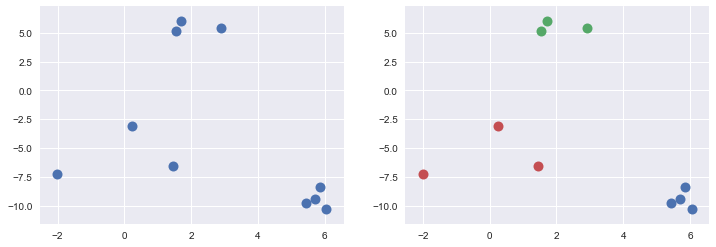

In [5]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o", ax=axes[0])
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o", ax=axes[1]);

Think of clustering as colouring the points (e.g., blue, red, green) such that points with the same color are close to each other. 

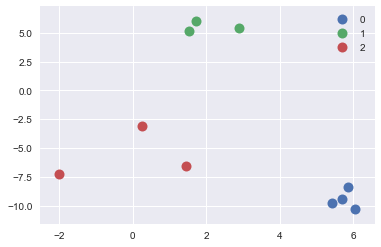

In [6]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o")
plt.legend();

- Usually the clusters are identified by a **cluster label**. 
- These labels are arbitrary, and relabeling the points (label switching) does not make a difference. 
- What we care about is which points have the same labels and which ones have different labels. 

### Is there a notion of "correct" grouping?

- Very often we do not know how many clusters are there in the data or if there are any clusters at all. In real-world data, clusters are rarely as clear as in our toy example above. 
- There is a notion of coherent and optimal (in some sense) clusters but there is no absolute truth here. 

### Example 1
Which of the following grouping of emoticons is the "correct" grouping?

<img src="img/emoticon_clustering_example.png" height="800" width="800"> 


Both seem reasonable! 

### Example 2

How would you group a deck of cards? 

- In a deck of cards:
    1. We have two colors: black and <font color="red">red</font>;
    2. We have four suits: Clubs, Spades, <font color="red">Hearts</font>, and <font color="red">Diamonds</font>;
    3. We have 13 values: $\left\{A,2,3,4,5,6,7,8,9,10,J,Q,K\right\}$.
    
- What are the "true" clusters here?    

Should we cluster by suits: Clubs, Spades, <font color="red">Hearts</font>, and <font color="red">Diamonds</font>?

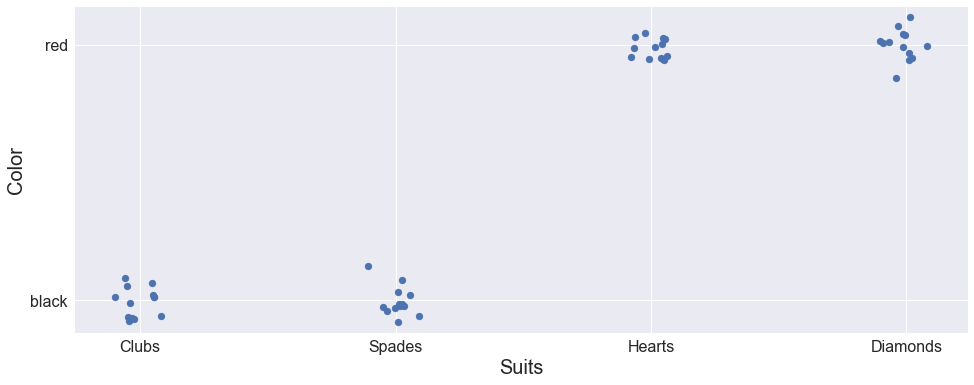

In [7]:
plot_deck(group_by="suits", w=16, h=6)

Should we cluster by colors?

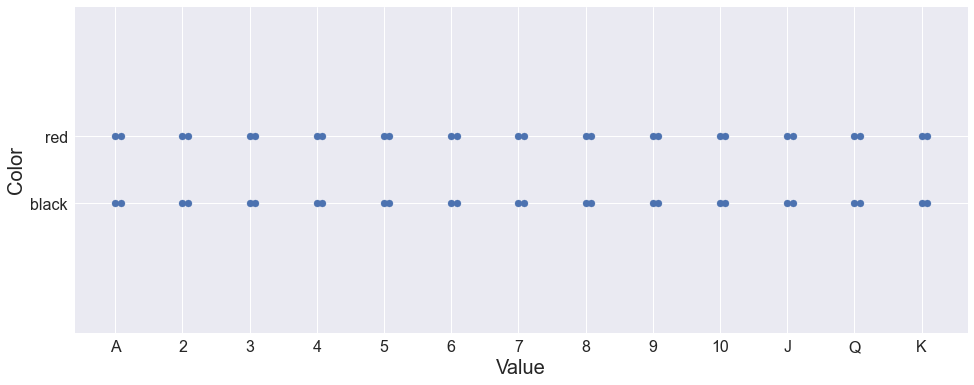

In [8]:
plot_deck(group_by="color", w=16, h=6)

Should we cluster by value?

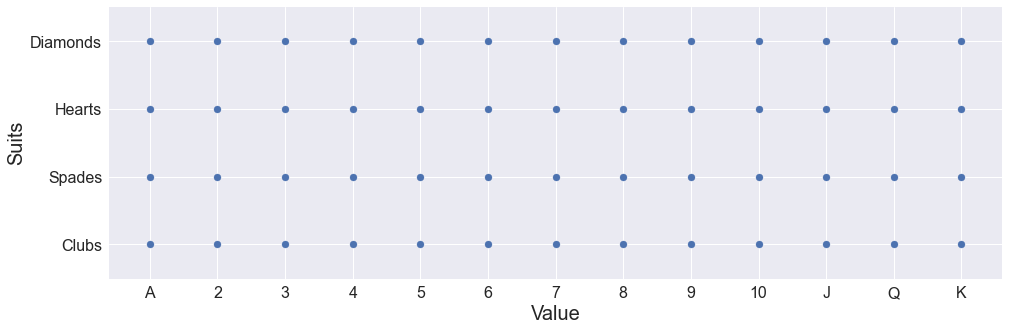

In [9]:
plot_deck(group_by="cards", w=16, h=5)

- All these options seem reasonable. 

### Meaningful groups in clustering 
- In clustering, meaningful groups are dependent on the **application**.
- It usually helps if we have some prior knowledge about the data and the problem.   
- This makes it hard for us to objectively measure the quality of a clustering algorithm (or think about "true" clusters).

### Common applications: Data exploration

Although there is no notion of the "right" answer, we might still get something useful out of clustering. There are a number of common applications for clustering. 

- Summarize or compress data. 
- Partition the data into groups before further processing. 
- For instance, you could use it in supervised learning setting as follows. Carry out clustering and examine performance of your model on individual clusters. If the performance is lower on a particular cluster, you could either try building a separate model for that cluster and improve the overall performance of your supervised model. 

### Common applications: Customer segmentation

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

<img src="img/customer-segmentation.png" height="600" width="600"> 
    
[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

### Document clustering

Grouping articles on different topics from different news sources. For example, [Google News](https://news.google.com). 

<img src="img/google_news.png" alt="" height="1200" width="1200">    

### Similarity and distances

- Clustering is based on the notion of similarity or distances between points. 
- How do we determine similarity between points in a multi-dimensional space?
- Can we use something like $k$-neighbours for similarity? 
    - Yes! That's a good start!  
    - With $k$-neighbours we used Euclidean distances to find nearby points. 
    - We can use the same idea for clustering! 


<br><br><br><br><br><br>

## K-Means clustering algorithm 

### K-Means clustering 

One of the most commonly used clustering algorithm. 

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points 



### K-Means using `sklearn`
- Before understanding the algorithm, let's try it with `sklearn`. 
- Consider the toy dataset above. 
- For this toy dataset, the three clusters are pretty clear.  

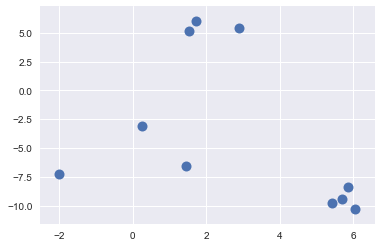

In [10]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [11]:
X

array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

In [12]:
toy_df = pd.DataFrame(data=X, columns=["feat1", "feat2"])
toy_df

,feat1,feat2
0,5.691924,-9.476412
1,1.707899,6.004352
2,0.236210,-3.119100
3,2.901595,5.421215
4,5.859439,-8.381924
5,6.047749,-10.305047
6,-2.007588,-7.247439
7,1.454677,-6.583872
8,1.536362,5.111215
9,5.430704,-9.759561


### `KMeans` `fit`
Let's try `sklearn`'s `KMeans` algorithm on this dataset.
- We need to decide how many clusters we want. Here we are passing 3. 
- We are only passing `X` because this is unsupervised learning; we do not have labels.  

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# We are only passing X because this is unsupervised learning

KMeans(n_clusters=3)

### `predict` of `KMeans`

- The output of `KMeans` is $K$ clusters (groups) of the data points. 
- Calling `predict` will give us the cluster assignment for each data point. 

In [14]:
kmeans.predict(X)

array([0, 1, 2, 1, 0, 0, 2, 2, 1, 0], dtype=int32)

In [15]:
toy_df_cl = toy_df.copy()
toy_df_cl["cluster"] = kmeans.predict(toy_df)
toy_df_cl

,feat1,feat2,cluster
0,5.691924,-9.476412,0
1,1.707899,6.004352,1
2,0.236210,-3.119100,2
3,2.901595,5.421215,1
4,5.859439,-8.381924,0
5,6.047749,-10.305047,0
6,-2.007588,-7.247439,2
7,1.454677,-6.583872,2
8,1.536362,5.111215,1
9,5.430704,-9.759561,0


### Cluster centers in  K-Means

- In K-Means each cluster is represented by its cluster center. 

In [16]:
kmeans.cluster_centers_

array([[ 5.75745416, -9.48073598],
       [ 2.04861878,  5.51226051],
       [-0.10556679, -5.65013704]])

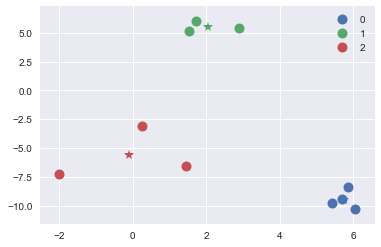

In [17]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*"
);

### K-Means predictions on new examples 
- We can also use `predict` on unseen examples!  

In [18]:
new_examples = np.array([[-1, -5], [2, 5.0]])
kmeans.predict(new_examples)

array([2, 1], dtype=int32)

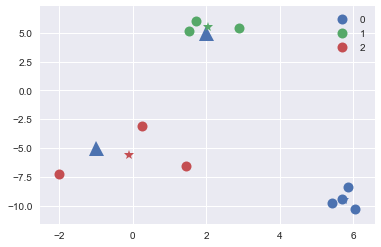

In [19]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
mglearn.discrete_scatter(new_examples[:, 0], new_examples[:, 1], markers="^", s=15)
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers="*"
);

### K-Means algorithm: Main idea 

- Represent each cluster by its cluster center and assign a cluster membership to each data point. 

**Chicken-and-egg problem!**

- If we knew cluster centers, we can simply assign each point to its nearest center.
- Similarly, if we knew assignments, we can calculate cluster centers.  
- But we do not know either 😟. 

A usual computer science answer to such problems is iterations!! 

### K-Means clustering algorithm

**Input**: Data points X and the number of clusters K

**Initialization**: K initial centers for the clusters

**Iterative process**:

repeat 
- Assign each example to the closest center.
- Estimate new centers as _average_ of observations in a cluster.

until **centers stop changing** or **maximum iterations have reached**.

Let's execute K-Means algorithm on our toy example. 

**Input**
- The data points `X`

In [20]:
n_examples = toy_df.shape[0]
print("Number of examples: ", n_examples)
X

Number of examples:  10


array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

- Let K (number of clusters) be 3. 

In [21]:
k = 3

### Initialization 

- Random initialization for K initial centers of the clusters. 

In [22]:
np.random.seed(seed=14)
centers_idx = np.random.choice(range(0, n_examples), size=k)
centers_df = toy_df.iloc[centers_idx]
centers = X[centers_idx]
colours = ["black", "blue", "red"]

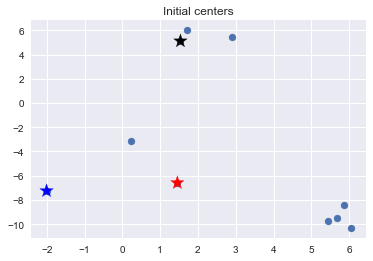

In [23]:
plt.scatter(X[:, 0], X[:, 1], marker="o")
plt.scatter(centers[:, 0], centers[:, 1], c=colours, marker="*", s=200)
plt.title("Initial centers");

### Iterative process

repeat 

- Assign each example to the closest center. (`update_Z`)
- Estimate new centers as _average_ of observations in a cluster. (`update_centers`)

until **centers stop changing** or **maximum iterations have reached**.

### How to find closest centers? 

- First step in the iterative process is assigning examples to the closest center. 
- Let's consider distance of an example to all centers and assign that example to the closest center.  

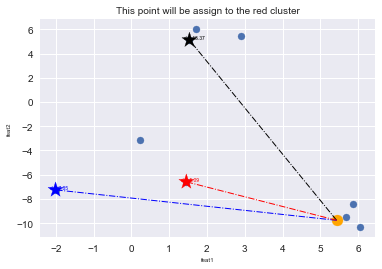

In [24]:
plot_example_dist(toy_df, centers_df, 6, 4)

### How to find closest centers?

- Similarly, we can make cluster assignments for all points by calculating distances of all examples to the centers and assigning it to the cluster with smallest distance.  

In [25]:
from sklearn.metrics import euclidean_distances


def update_Z(X, centers):
    """
    returns distances and updated cluster assignments
    """
    dist = euclidean_distances(X, centers)
    return dist, np.argmin(dist, axis=1)

### How to update centers?   

- With the new cluster assignments for our data points, we update cluster centers. 
- New cluster centers are means of data points in each cluster. 

In [26]:
def update_centers(X, Z, old_centers, k):
    """
    returns new centers
    """
    new_centers = old_centers.copy()
    for kk in range(k):
        new_centers[kk] = np.mean(X[Z == kk], axis=0)
    return new_centers

### Iteration 1: Step 1 

- Assign each example to the closest cluster center.

In [27]:
dist, Z = update_Z(X, centers)
Z

array([2, 0, 2, 0, 2, 2, 1, 2, 0, 2])

- This is the current cluster assignment. 

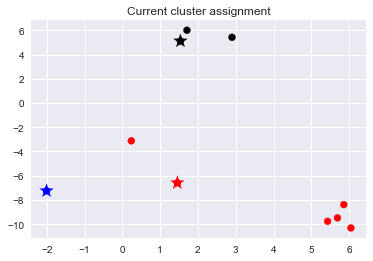

In [28]:
plot_current_assinment(X, Z, centers)

### Iteration 1: Step 2 
- Estimate new centers as _average_ of observations in a cluster.

In [29]:
new_centers_it1 = update_centers(X, Z, centers, k)

- This is how the centers moved in this iteration. 

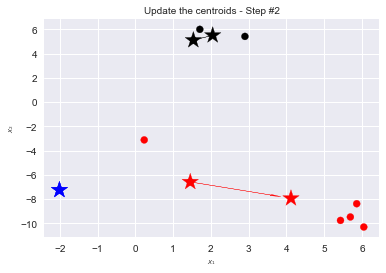

In [30]:
plot_update_centroid(toy_df, 6, 4, new_centers_it1, centers, dist)

### Iteration 2: step 1

- Assign each example to the closest cluster center.

In [31]:
dist, Z = update_Z(X, new_centers_it1)
Z

array([2, 0, 1, 0, 2, 2, 1, 2, 0, 2])

- This is the current cluster assignment. 

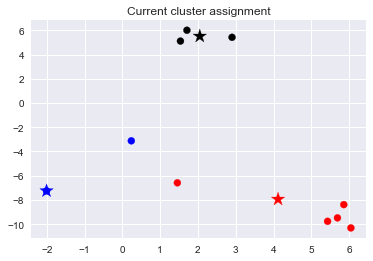

In [32]:
plot_current_assinment(X, Z, new_centers_it1)

### Iteration 2: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [33]:
new_centers_it2 = update_centers(X, Z, new_centers_it1, k)

- This is how the centers moved in this iteration. 

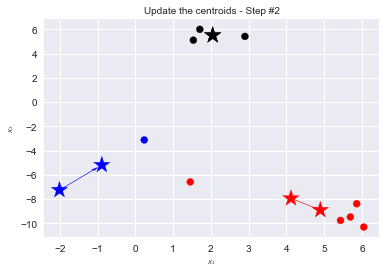

In [34]:
plot_update_centroid(toy_df, 6, 4, new_centers_it2, new_centers_it1, dist)

### Iteration 3: step 1

- Assign each example to the closest cluster center.

In [35]:
dist, Z = update_Z(X, new_centers_it2)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2])

- This is the current cluster assignment. 

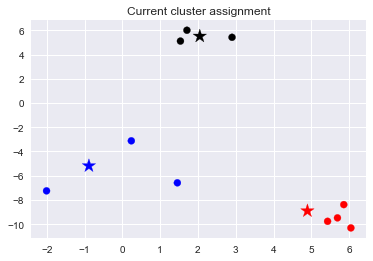

In [36]:
plot_current_assinment(X, Z, new_centers_it2)

### Iteration 3: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [37]:
new_centers_it3 = update_centers(X, Z, new_centers_it2, k)

- This is how the centers moved in this iteration. 

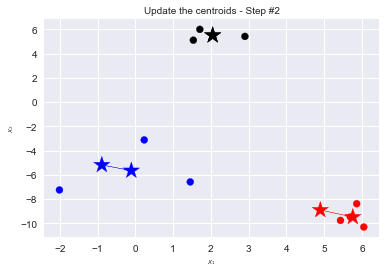

In [38]:
plot_update_centroid(toy_df, 6, 4, new_centers_it3, new_centers_it2, dist)

### Iteration 4: step 1

- Assign each example to the closest cluster center.

In [39]:
dist, Z = update_Z(X, new_centers_it3)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2])

- This is the current cluster assignment. 

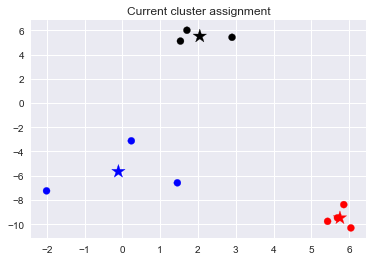

In [40]:
plot_current_assinment(X, Z, new_centers_it3)

### Iteration 4: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [41]:
new_centers_it4 = update_centers(X, Z, new_centers_it3, k)

- The cluster centers are not moving anymore. 

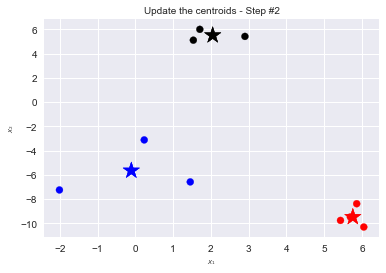

In [42]:
plot_update_centroid(toy_df, 6, 4, new_centers_it4, new_centers_it3, dist)

### Iteration 5: step 1

- Assign each example to the closest cluster center.

In [43]:
dist, Z = update_Z(X, new_centers_it4)
Z

array([2, 0, 1, 0, 2, 2, 1, 1, 0, 2])

- This is the current cluster assignment.

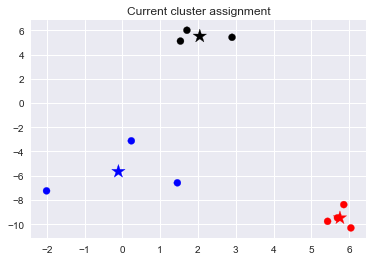

In [44]:
plot_current_assinment(X, Z, new_centers_it4)

### Iteration 5: step 2

- Estimate new centers as _average_ of observations in a cluster.

In [45]:
new_centers_it5 = update_centers(X, Z, new_centers_it4, k)

- The cluster centers are not moving anymore. 

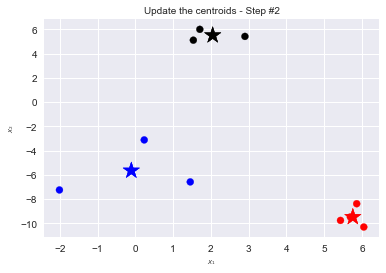

In [46]:
plot_update_centroid(toy_df, 6, 4, new_centers_it5, new_centers_it4, dist)

### When to stop?

- Seems like our centroids aren't changing anymore. 
- The algorithm has converged. So we stop! 
- K-Means always converges. It doesn't mean it finds the "right" clusters. It can converge to a sub-optimal solution.   

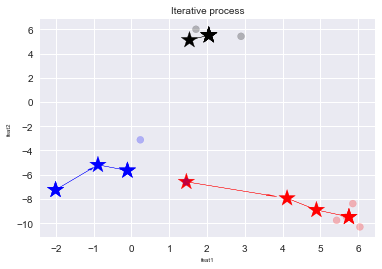

In [47]:
plot_iterative(toy_df, 6, 4, centers)

Initialization is crucial. We'll talk about it in a bit. 

### Example 2
- Let's use the K-means on the iris dataset. 

In [48]:
## Iris dataset
iris = datasets.load_iris()  # loading the iris dataset
features = iris.data  # get the input data
labels = iris.target_names[
    iris.target
]  # get the targets, in this case the types of the Iris flower

iris_df = pd.DataFrame(features, columns=iris.feature_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [49]:
np.unique(labels)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [50]:
# Reducing the dimensionality for plotting purposes
# (We're going to learn more about it later in the course)
pca = PCA(n_components=2)
pca.fit(features)
data_iris = pd.DataFrame(pca.transform(features), columns=["$Z_1$", "$Z_2$"])
data_iris["target"] = labels

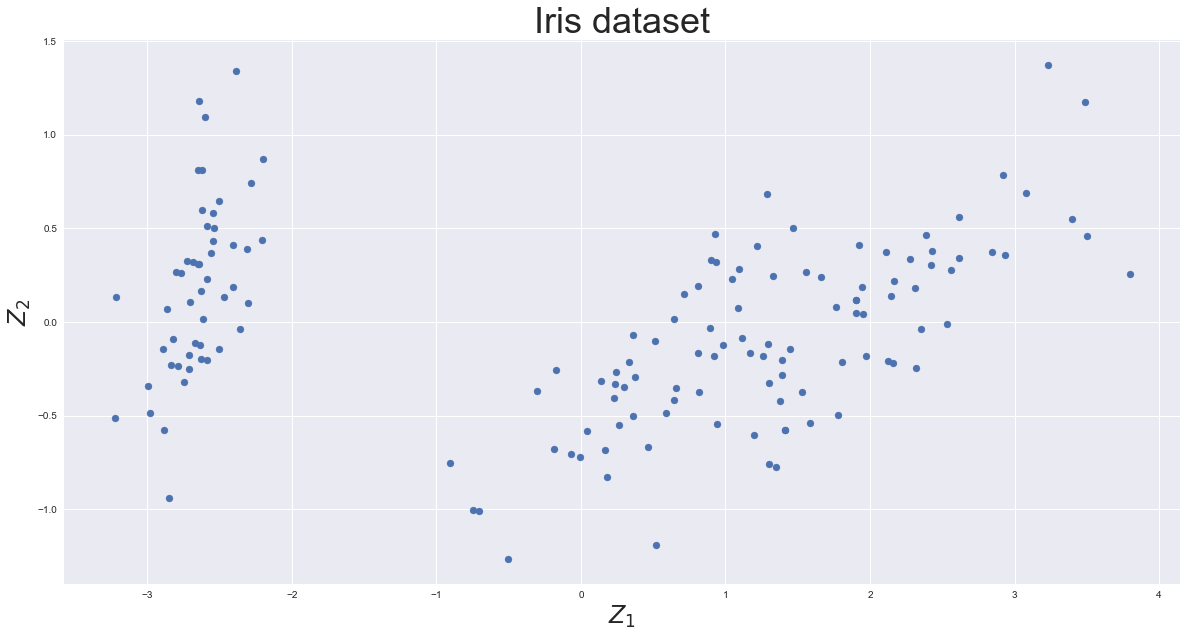

In [51]:
plot_unsup(data_iris, 20, 10, "Iris dataset")

#### Initialization

- In this case, we know that $k=3$;
- We are going to pick three points at random to use as initial centroids;

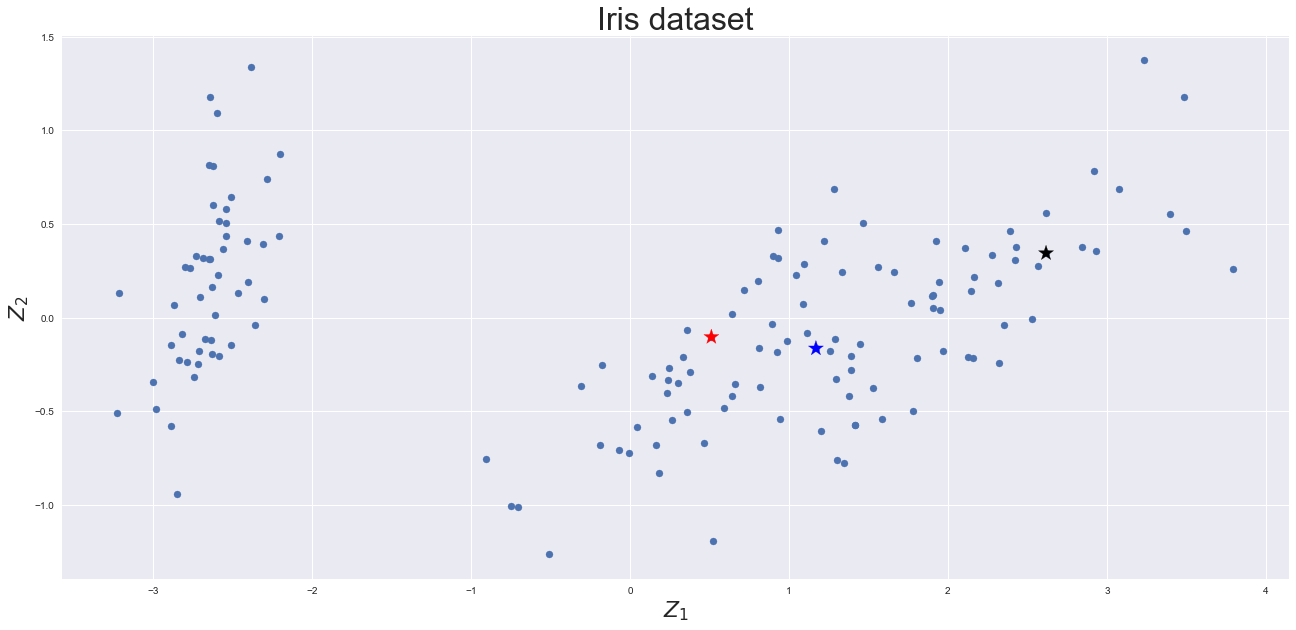

In [52]:
# RANDOM initialization
k = 3
centroids = np.random.choice(range(0, 150), size=k)
centroids = data_iris.iloc[centroids, 0:2]
plot_intial_center(data_iris, centroids, 22, 10, title="Iris dataset")

- Next, for each point in the dataset, we calculate the distance to each one of the centroids; 


- Let's do it for one point as example:

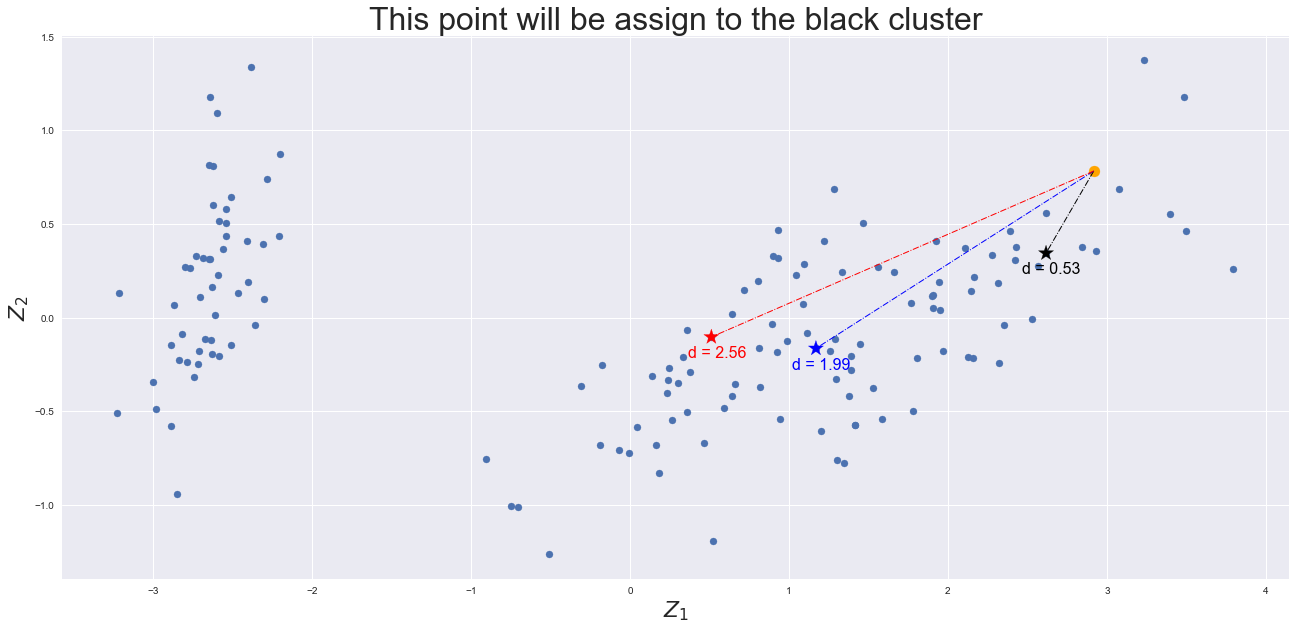

In [53]:
plot_example_dist(data_iris, centroids, 22, 10)

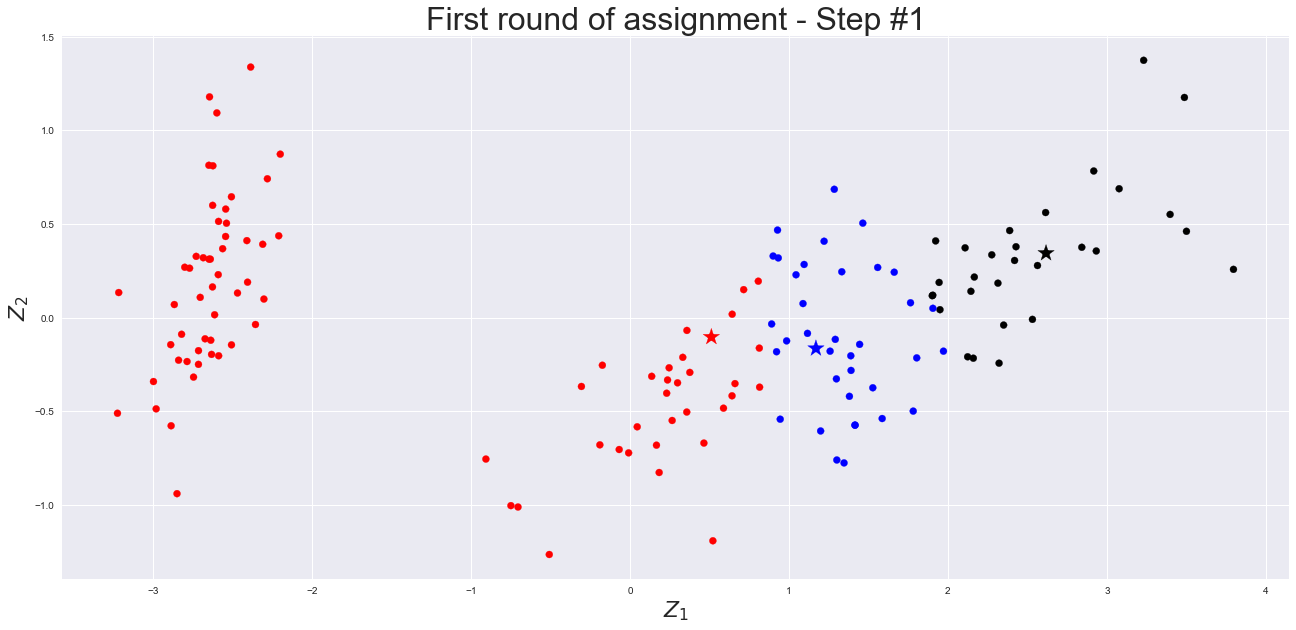

In [54]:
dist = distance.cdist(data_iris.iloc[:, 0:2], centroids.iloc[:, 0:2])
plot_first_assignment(data_iris, centroids, dist, 22, 10)

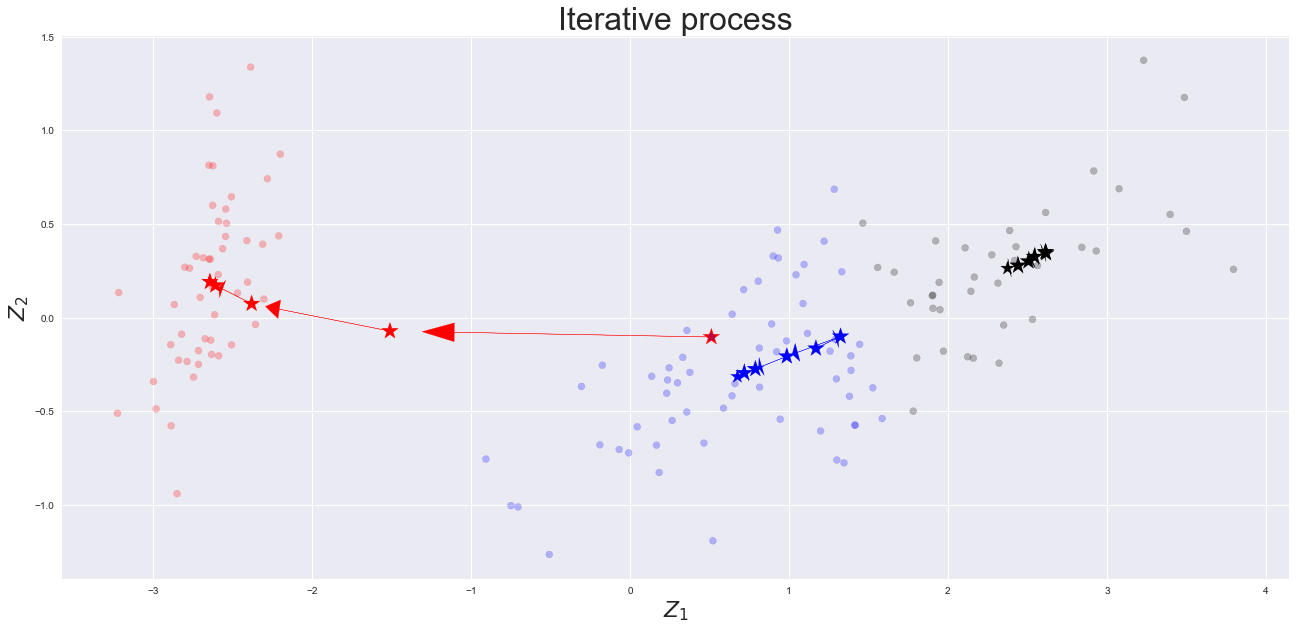

In [55]:
plot_iterative(data_iris, 22, 10, centroids.to_numpy())

### (Optional) Feature engineering using K-Means 

- K-Means could be used for feature engineering in supervised learning. 
- Examples: 
    - You could add a categorical feature: cluster membership
    - You could add a continuous features: distance from each cluster center
- See [this paper](http://ai.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf).

<br><br><br><br>

## Choosing K <a name="3"></a>

### Hyperparameter tuning for K

- K-Means takes K (`n_clusters` in `sklearn`) as a hyperparameter. How do we pick K? 

- In supervised setting we carried out hyperparameter optimization based on cross-validation scores. 

- Since in unsupervised learning we do not have the target values, it becomes difficult to objectively measure the effectiveness of the algorithms.

- There is no definitive approach.

- However, some strategies might be useful to help you determine K. 

### Method 1: The Elbow method

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**. 
- The intra-cluster distance in our toy example above is given as   

$$ \sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where 
- $C_1, C_2, C_3$ are centroids 
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance. 

### Inertia 

You can access this intra-cluster distance or inertia as follows. 

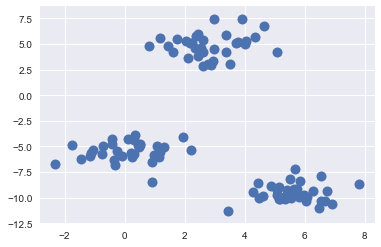

In [56]:
X, y = make_blobs(centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [57]:
d = {"K": [], "inertia": []}
for k in range(1, 100, 10):
    model = KMeans(n_clusters=k).fit(X)
    d["K"].append(k)
    d["inertia"].append(model.inertia_)

In [58]:
pd.DataFrame(d)

,K,inertia
0,1,4372.460950
1,11,58.474524
2,21,26.900485
3,31,12.770892
4,41,6.421834
5,51,3.593682
6,61,1.961654
7,71,0.945421
8,81,0.322479
9,91,0.053156


- The inertia decreases as K increases. 
- Question: Do we want inertia to be small or large? 
- The problem is that we can't just look for a $k$ that minimizes inertia because it decreases as $k$ increases.
    - If I have number of clusters = number of examples, each example will have its own cluster and the intra-cluster distance will be 0.  
- Instead we evaluate the trade-off: "small k" vs "small intra-cluster distances". 

In [59]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

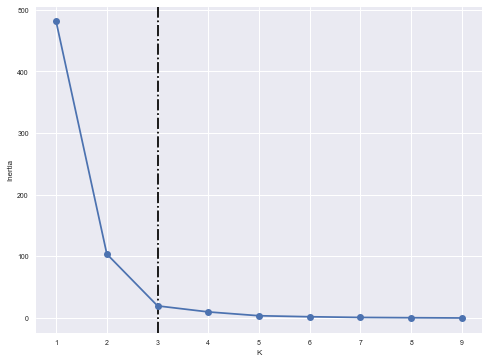

In [60]:
inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k).fit(toy_df).inertia_)
plot_elbow(8, 6, inertia_values)

- From the above plot, we could argue that three clusters (the point of inflection on the curve) are enough.
- The inertia decreases when clusters are greater than 3. However it's not a big improvement and so we prefer K=3. 
- In this toy example, it's the plot is kind of clear and easy to interpret but it can be hard to interpret in real life examples. 

There is a package called [`yellowbrick`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) which can be used to create these plots conveniently. 

```
conda install -c districtdatalabs yellowbrick
```

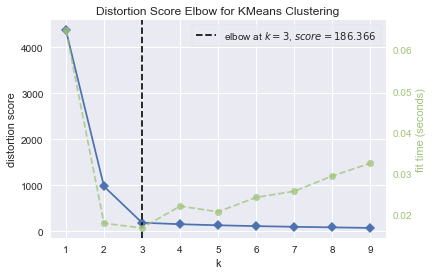

In [61]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show();

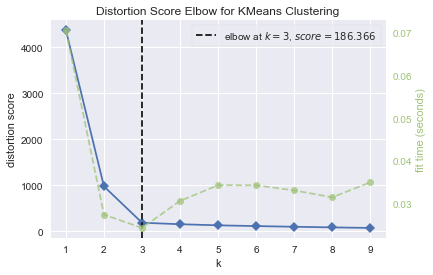

In [62]:
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.finalize();

In [63]:
visualizer.draw()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

### Method 2: The Silhouette method

- Not dependent on the notion of cluster centers. 
- Calculated using the **mean intra-cluster distance** ($a$) and the **mean nearest-cluster distance** ($b$) for each sample.

### Mean intra-cluster distance ($a$)

- Suppose the green point below is our sample. 
- Average of the distances of the green point to the other points in the same cluster.
  - These distances are represented by the black lines. 
  

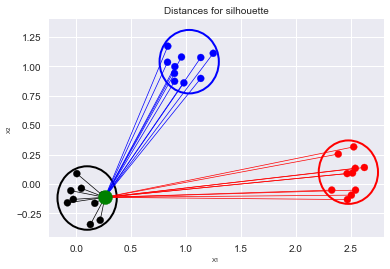

In [64]:
plot_silhouette_dist(6, 4)

### Mean nearest-cluster distance ($b$)

- Average of the distances of the green point to the blue points is smaller than the average of the distances of the green point to the red points. So the **nearest cluster** is the blue cluster. 
- So the mean nearest-cluster distance is the average of the distances of the green point to the blue points.  

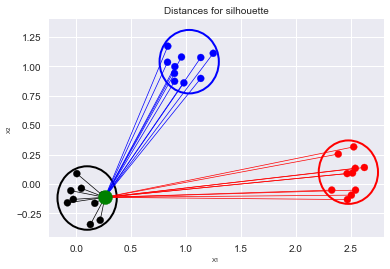

In [65]:
plot_silhouette_dist(6, 4)

### Silhouette distance for a sample 

- the difference between the **the average nearest-cluster distance** ($b$) and **average intra-cluster distance** ($a$) for each sample, normalized by the maximum value

$$\frac{b-a}{max(a,b)}$$

- The best value is 1. 
- The worst value is -1 (samples have been assigned to wrong clusters).
- Value near 0 means overlapping clusters. 

The overall **Silhouette score** is the average of the Silhouette scores for all samples. 

### Using Silhouette scores to select the number of clusters

- The plots below show the Silhouette scores for each sample in that cluster. 
- Higher values indicate well-separated clusters. 
- The size of the Silhouette shows the number of samples and hence shows imbalance of data points in clusters.  

In [66]:
from yellowbrick.cluster import SilhouetteVisualizer

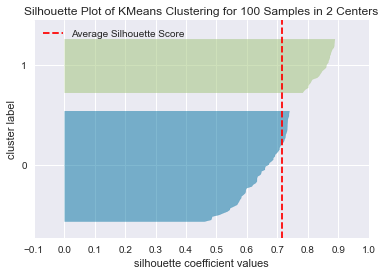

In [67]:
model = KMeans(2, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

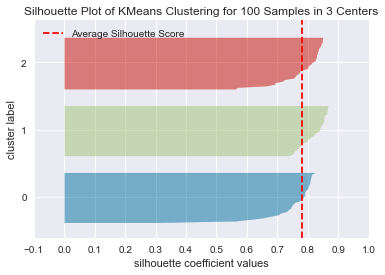

In [68]:
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

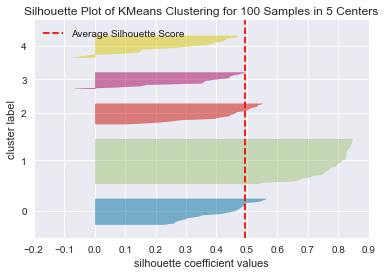

In [69]:
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

### What to look for in these plots?

- Unlike inertia, larger values are better because they indicate that the point is further away from neighbouring clusters.
- The thickness of each silhouette indicates the cluster size.
- The shape of each silhouette indicates the "goodness" for points in each cluster.
- The length (or area) of each silhouette indicates the goodness of each cluster.
- A slower dropoff (more rectangular) indicates more points are "happy" in their cluster.

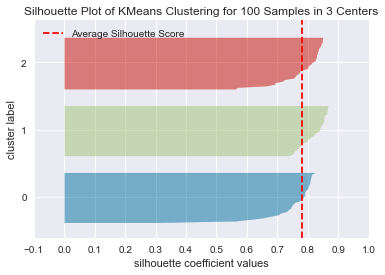

In [70]:
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

### Comments on Silhouette scores 
- Unlike inertia, larger values are better because they indicate that the point is further away from neighbouring clusters.
- Unlike inertia, the overall silhouette score gets worse as you add more clusters because you end up being closer to neighbouring clusters.
- Thus, as with intertia, you will not see a "peak" value of this metric that indicates the best number of clusters.
- We can visualize the silhouette score for each example individually in a silhouette plot (hence the name), see below.
- We can apply Silhouette method to clustering methods other than K-Means. 


### K-Means: True/False questions

- The preprocessing methods such as scaling and imputation are unsupervised methods. 
- K-Means algorithm always converges to the same solution.
- $K$ in K-Means should always be $\leq$ # of features.
- In K-Means, it makes sense to have $K$ $\leq$ # of examples. 

<br><br><br><br>

### K-Means: True/False questions 

- In some iterations some points may be left unassigned. 
- K-Means is sensitive to initialization and the solution may change depending upon the initialization. 
- K-means terminates when the number of clusters does not increase between iterations.
- K-means terminates when the centroid locations do not change between iterations. 

<br><br><br><br>

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

## K-Means case study: Customer segmentation

### What is customer segmentation? 

Check out [this interesting talk by Malcom Gladwell](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en). Humans are diverse and there is no single spaghetti sauce that would make all of them happy! 

Often it's beneficial to businesses to explore the landscape of the market and tailor their services and products offered to each group. This is called **customer segmentation**. It's usually applied when the dataset contains some of the following features. 

- **Demographic information** such as gender, age, marital status, income, education, and occupation
- **Geographical information** such as specific towns or counties or a customer's city, state, or even country of residence (in case of big global companies)
- **Psychographics** such as social class, lifestyle, and personality traits
- **Behavioral data** such as spending and consumption habits, product/service usage, and desired benefits 

### Business problem 

- Imagine that you are hired as a data scientist at a bank. They provide some data of their credit card customers to you. 
- Their goal is to develop customized marketing campaigns and they ask you to group customers based on the given information. 
- Now that you know about K-Means clustering, let's apply it to the dataset to group customers. 

### Data

- We will use the [Credit Card Dataset for clustering](https://www.kaggle.com/arjunbhasin2013/ccdata) from Kaggle.
- Download the data and save the CSV under the `data` folder. 
- I encourage you to work through this case study on your own. 

In [71]:
creditcard_df = pd.read_csv("data/CC General.csv")
creditcard_df.shape

(8950, 18)

### Information of the dataset 

We have behavioral data. 

- CUSTID: Identification of Credit Card holder
- BALANCE: Balance amount left in customer's account to make purchases
- BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES: Amount of purchases made from account
- ONEOFFPURCHASES: Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES: Amount of purchase done in installment
- CASH_ADVANCE: Cash in advance given by the user
- PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
- CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
- PURCHASES_TRX: Number of purchase transactions made
- CREDIT_LIMIT: Limit of Credit Card for user
- PAYMENTS: Amount of Payment done by user
- MINIMUM_PAYMENTS: Minimum amount of payments made by user
- PRC_FULL_PAYMENT: Percent of full payment paid by user
- TENURE: Tenure of credit card service for user

### Preliminary EDA

In [72]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

- All numeric features
- Some missing values

In [73]:
creditcard_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Practice exercises for you

1. What is the average `BALANCE` amount?
2. How often the `BALANCE_FREQUENCY` is updated on average? 
3. Obtain the row the customer who made the maximum cash advance transaction. 

<br><br><br><br>

### Mini exercises for you (Answers)

1. What is the average `BALANCE` amount? 1564.47
2. How often the `BALANCE_FREQUENCY` is updated on average? 0.88 (pretty often) 
3. Obtain the row of the customer who made the maximum cash advance transaction. 

In [74]:
max_cash_advance = creditcard_df["CASH_ADVANCE"].max()
creditcard_df[creditcard_df["CASH_ADVANCE"] == max_cash_advance]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


Let's examine correlations between features. 

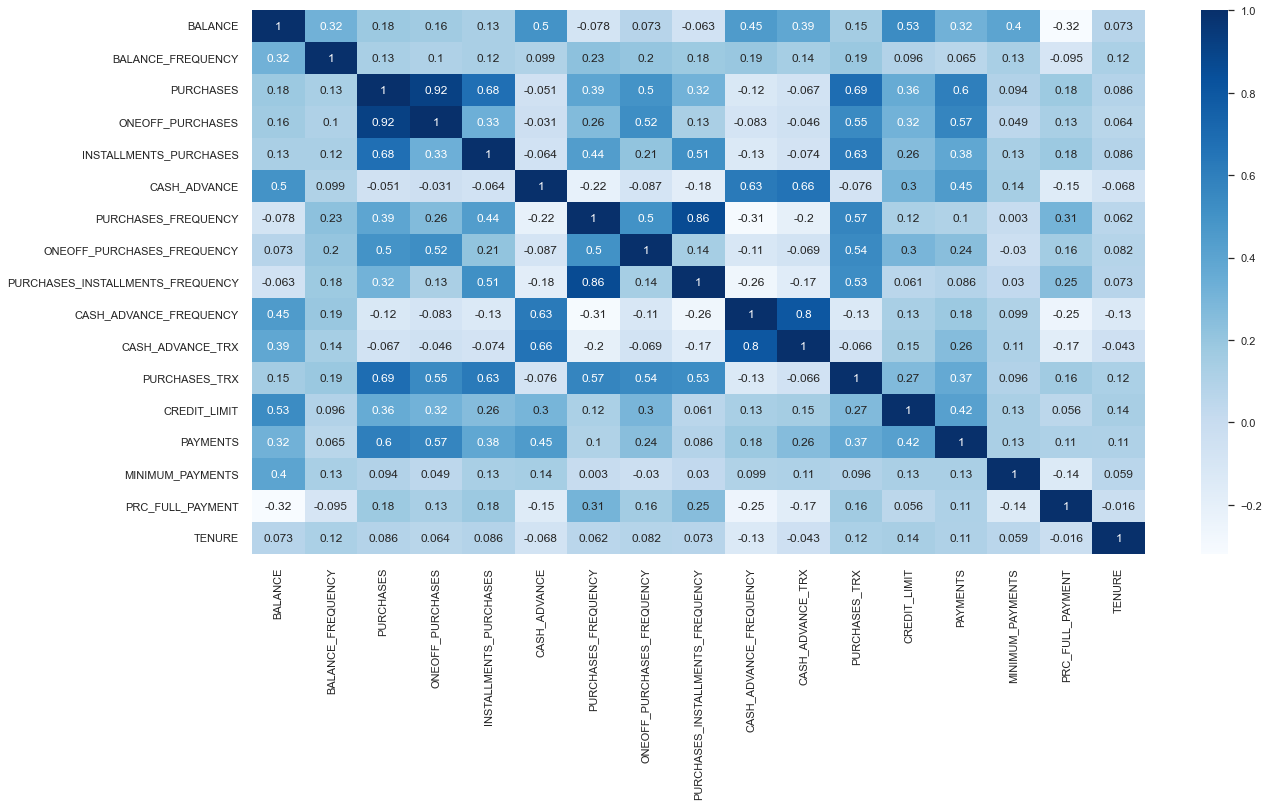

In [75]:
cor = creditcard_df.corr()
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

### Feature types and preprocessing 

Let's identify different feature types and transformations 

In [76]:
creditcard_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [77]:
drop_features = ["CUST_ID"]
numeric_features = list(set(creditcard_df.columns) - set(drop_features))

In [78]:
from sklearn.impute import SimpleImputer

numeric_transformer = make_pipeline(SimpleImputer(), StandardScaler())

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), ("drop", drop_features)
)

In [79]:
transformed_df = pd.DataFrame(
    data=preprocessor.fit_transform(creditcard_df), columns=numeric_features
)

In [80]:
transformed_df

,MINIMUM_PAYMENTS,PAYMENTS,TENURE,BALANCE_FREQUENCY,CASH_ADVANCE_TRX,PRC_FULL_PAYMENT,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,ONEOFF_PURCHASES_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,BALANCE,CREDIT_LIMIT,PURCHASES_INSTALLMENTS_FREQUENCY,INSTALLMENTS_PURCHASES,ONEOFF_PURCHASES,CASH_ADVANCE
0,-3.109675e-01,-0.528979,0.360680,-0.249434,-0.476070,-0.525551,-0.675349,-0.511333,-0.678661,-0.424900,-0.806490,-0.731989,-0.960433,-0.707313,-0.349079,-0.356934,-0.466786
1,8.931021e-02,0.818642,0.360680,0.134325,0.110074,0.234227,0.573963,-0.591796,-0.678661,-0.469552,-1.221758,0.786961,0.688639,-0.916995,-0.454576,-0.356934,2.605605
2,-1.016632e-01,-0.383805,0.360680,0.518084,-0.476070,-0.525551,-0.675349,-0.109020,2.673451,-0.107668,1.269843,0.447135,0.826062,-0.916995,-0.454576,0.108889,-0.466786
3,4.878305e-17,-0.598688,0.360680,-1.016953,-0.329534,-0.525551,-0.258913,-0.551565,-0.399319,0.232058,-1.014125,0.049099,0.826062,-0.916995,-0.454576,0.546189,-0.368653
4,-2.657913e-01,-0.364368,0.360680,0.518084,-0.476070,-0.525551,-0.675349,-0.551565,-0.399319,-0.462063,-1.014125,-0.358775,-0.905464,-0.916995,-0.454576,-0.347294,-0.466786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-3.498541e-01,-0.486217,-4.122768,0.518084,-0.476070,1.183951,-0.675349,-0.350408,-0.678661,-0.333293,1.269843,-0.737950,-0.960433,1.179833,-0.132643,-0.356934,-0.466786
8946,4.878305e-17,-0.503396,-4.122768,0.518084,-0.476070,-0.525551,-0.675349,-0.350408,-0.678661,-0.329136,1.269843,-0.742423,-0.960433,1.179833,-0.122823,-0.356934,-0.466786
8947,-3.354655e-01,-0.570615,-4.122768,-0.185477,-0.476070,0.329200,-0.675349,-0.390639,-0.678661,-0.401965,0.854576,-0.740398,-0.960433,0.760469,-0.294893,-0.356934,-0.466786
8948,-3.469065e-01,-0.580536,-4.122768,-0.185477,-0.182998,0.329200,0.157527,-0.591796,-0.678661,-0.469552,-1.221758,-0.745174,-1.097856,-0.916995,-0.454576,-0.356934,-0.449352


Now that we have transformed the data, we are ready to run K-Means to cluster credit card customers. 

### Tuning the hyperparameter `n_clusters`

- Let's first obtain optimal number of clusters using the Elbow method. 

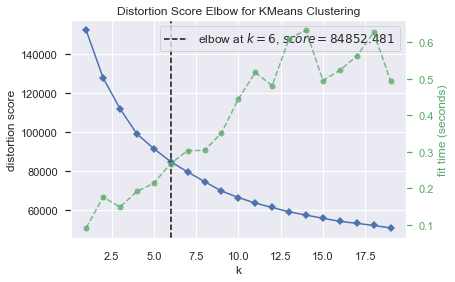

In [81]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 20))

visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show();

- The optimal number of clusters is not as clear as it was in our toy example. 

- Let's examine Silhouette scores.  

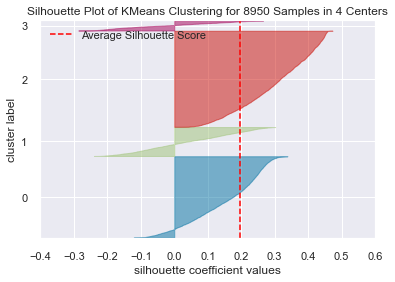

In [82]:
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

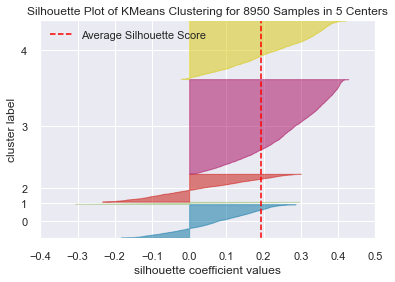

In [83]:
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

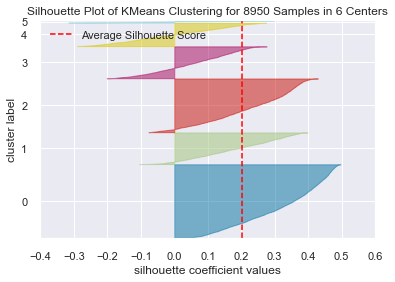

In [84]:
model = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

- I'm going to run `KMeans` with `n_clusters = 4`. 
- You can try out `n_clusters = 5` and `n_clusters = 6` on your own. 

In [85]:
kmeans = KMeans(4, random_state=123)
kmeans.fit(transformed_df)
labels = kmeans.labels_
kmeans.cluster_centers_.shape

(4, 17)

- Let's visualize the clusters in two dimensions using PCA, which is a popular dimensionality reduction technique.  
- We won't be talking about PCA in this course but I'll be using it for visualization. 

In [86]:
# Obtain the principal components
from sklearn.decomposition import PCA


def plot_pca_clusters(data, labels):
    """
    Carries out dimensionality reduction on the data for visualization
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        data=principal_comp, columns=["pca1", "pca2"], index=data.index
    )
    pca_df["cluster"] = labels
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10"
    )
    plt.show()

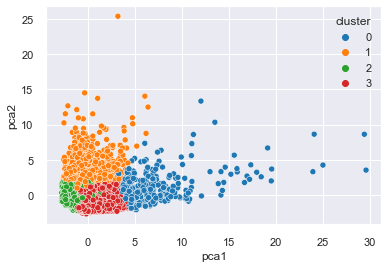

In [87]:
plot_pca_clusters(transformed_df, kmeans.labels_)

- The clusters above look reasonably well separated. 
- This might not always be the case. 

### Cluster interpretation

- Let's examine the cluster centers and identify types of customers.  

In [88]:
cluster_centers = pd.DataFrame(
    data=kmeans.cluster_centers_, columns=[transformed_df.columns]
)
cluster_centers

,MINIMUM_PAYMENTS,PAYMENTS,TENURE,BALANCE_FREQUENCY,CASH_ADVANCE_TRX,PRC_FULL_PAYMENT,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,ONEOFF_PURCHASES_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,BALANCE,CREDIT_LIMIT,PURCHASES_INSTALLMENTS_FREQUENCY,INSTALLMENTS_PURCHASES,ONEOFF_PURCHASES,CASH_ADVANCE
0,0.477421,1.919096,0.324140,0.462694,-0.170458,0.454703,-0.319096,3.003251,1.798653,3.125845,1.136338,0.954485,1.429882,1.065918,2.406470,2.713251,-0.155091
1,0.490910,0.603821,-0.097146,0.384753,1.617143,-0.406367,1.745948,-0.283580,-0.212939,-0.234638,-0.504848,1.459578,0.838968,-0.450201,-0.253747,-0.163914,1.688972
2,-0.119249,-0.262060,-0.052972,-0.368944,-0.164607,-0.258866,-0.101500,-0.474987,-0.389437,-0.343190,-0.797823,-0.265552,-0.334417,-0.714246,-0.387798,-0.230500,-0.182691
3,-0.091844,-0.138502,0.057744,0.242574,-0.360303,0.395041,-0.462599,0.296985,0.317153,0.109044,0.983721,-0.321688,-0.077298,0.874138,0.255904,0.000926,-0.366373


- Recall that we have applied imputation and scaling on the dataset. 
- But we would be able to interpret these clusters better if the centers are in the original scale. 
- So let's apply inverse transformations to get the cluster center values in the original scale. 

In [89]:
data = (
    preprocessor.named_transformers_["pipeline"]
    .named_steps["standardscaler"]
    .inverse_transform(cluster_centers[numeric_features])
)

In [90]:
org_cluster_centers = pd.DataFrame(data=data, columns=numeric_features)
org_cluster_centers = org_cluster_centers.reindex(
    sorted(org_cluster_centers.columns), axis=1
)
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595


In [91]:
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595


#### Transactors
- Credit card users who pay off their balance every month with least amount of interest charges. 
- They are careful with their money. 
- They have lowest balance and cash advance


In [92]:
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595


#### Revolvers
- Credit card users who pay off only part of their monthly balance . They use credit card as a loan.  
- They have highest balance and cash advance, high cash advance frequency, low purchase frequency, high cash advance transactions, low percentage of full payment
- Their credit limit is also high. (Lucrative group for banks 😟.)

In [93]:
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595


#### VIP/Prime
- Credit card users who have high credit limit. 
- They have high one-off purchases frequency, high number of purchase transactions. 
- They have high balance but they also have relatively higher percentage of full payment, similar to transactors
- Target for increase credit limit (and increase spending habits )

In [94]:
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595


#### Low activity
- Credit card users who have low tenure, low credit limit.
- There is not much activity in the account. It has low balance and not many purchases. 

### More on interpretation of clusters

- In real life, you'll look through all features in detail before assigning meaning to clusters. 
- This is not always easy, especially when you have a large number of features and clusters. 
- One way to approach this would be visualizing the distribution of feature values for each cluster as shown below. 
- Some domain knowledge would definitely help at this stage.  

In [95]:
# concatenate the cluster labels to our original dataframe
creditcard_df_cluster = pd.concat(
    [creditcard_df, pd.DataFrame({"cluster": labels})], axis=1
)
creditcard_df_cluster.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,2
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,2
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,2


In [96]:
creditcard_df_cluster["cluster"].unique()

array([2, 1, 3, 0], dtype=int32)

In [97]:
creditcard_df.columns.shape

(18,)

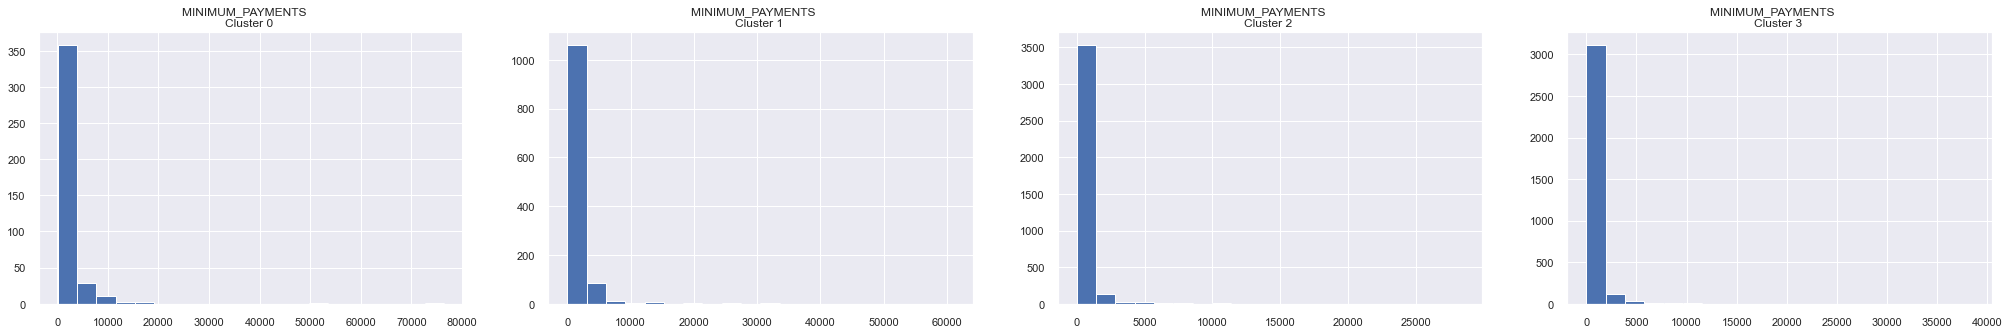

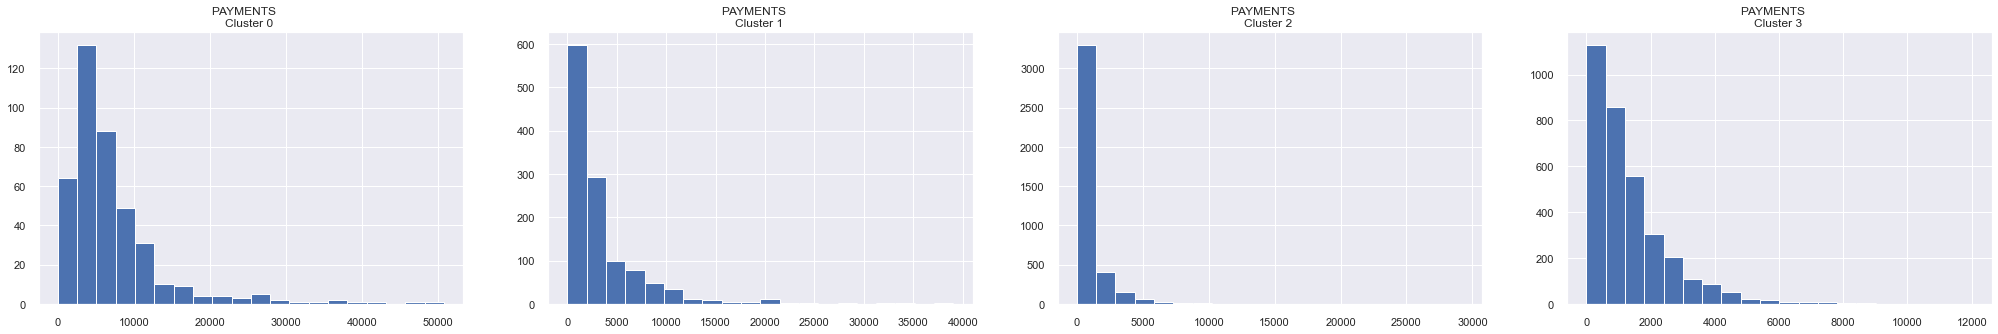

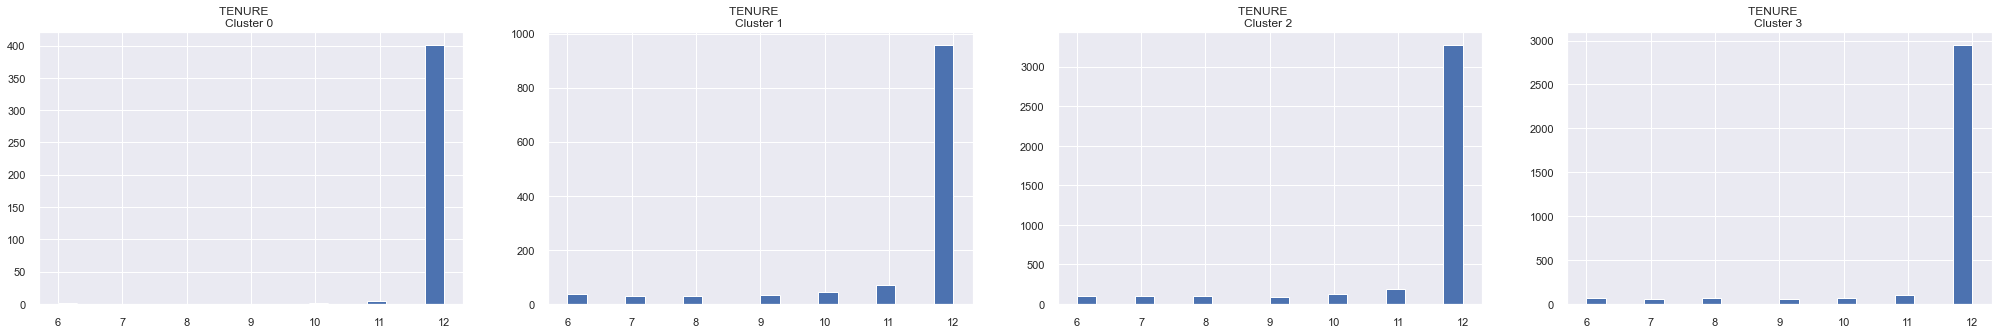

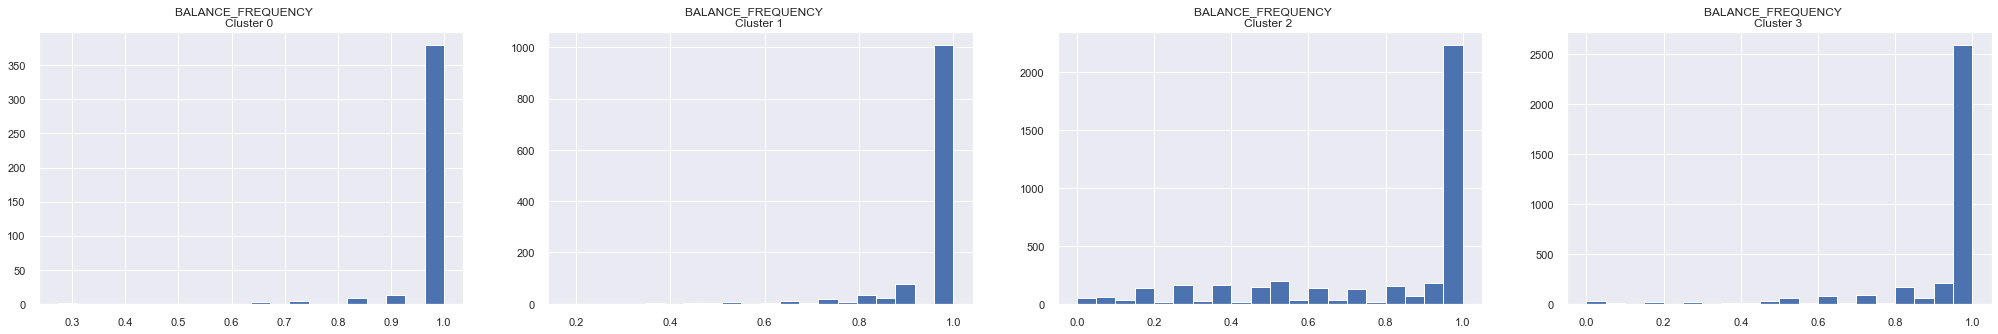

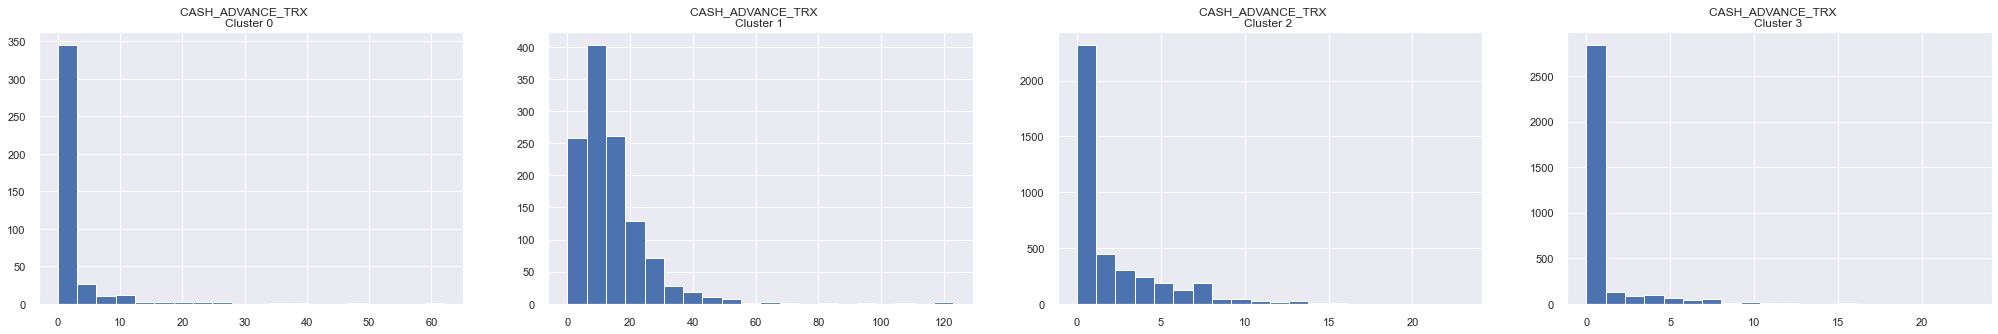

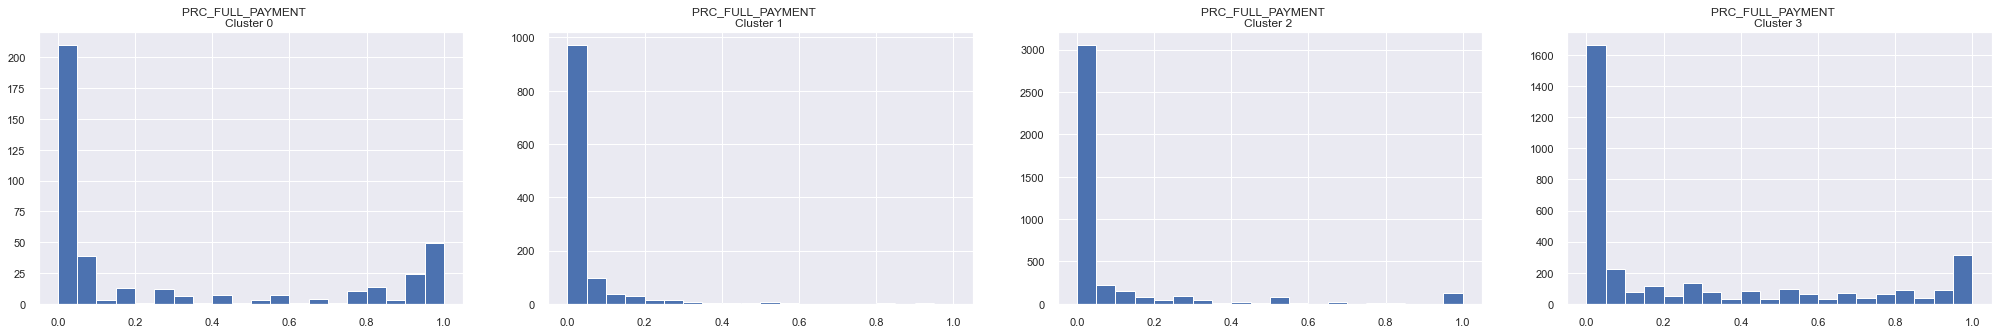

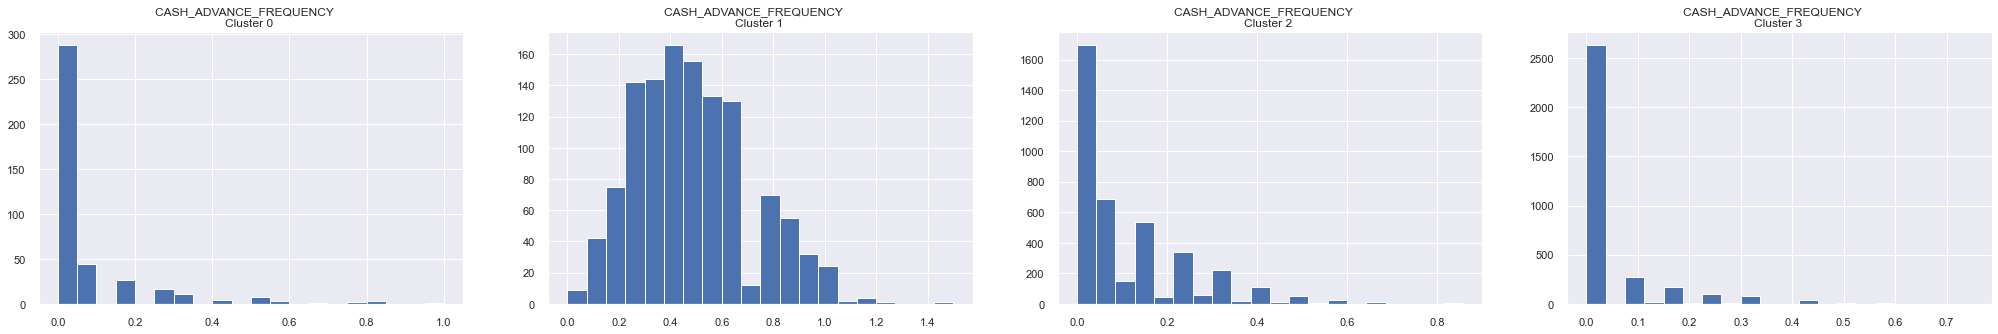

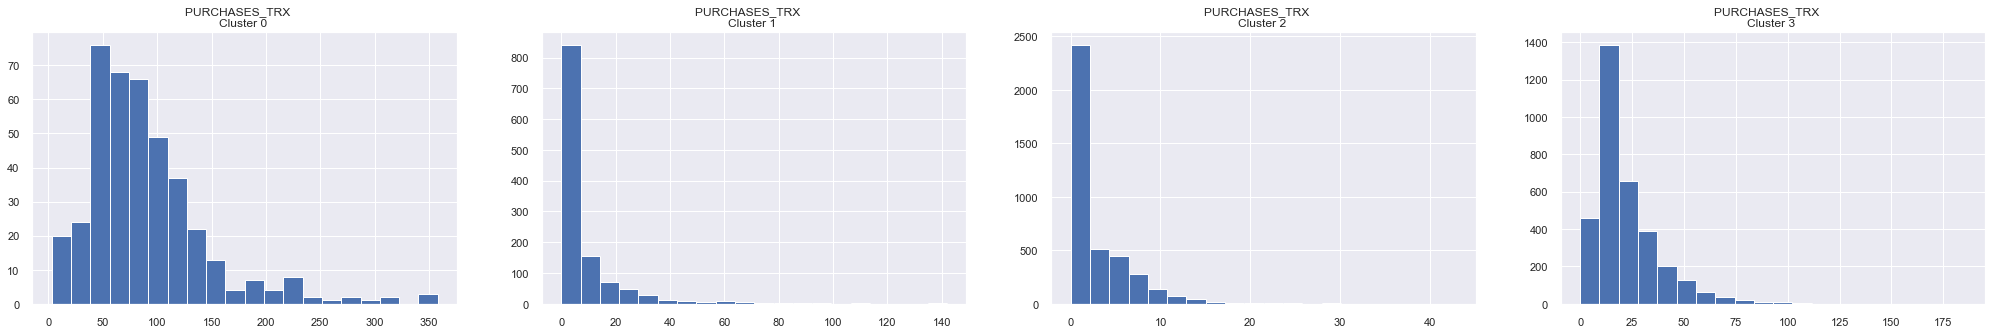

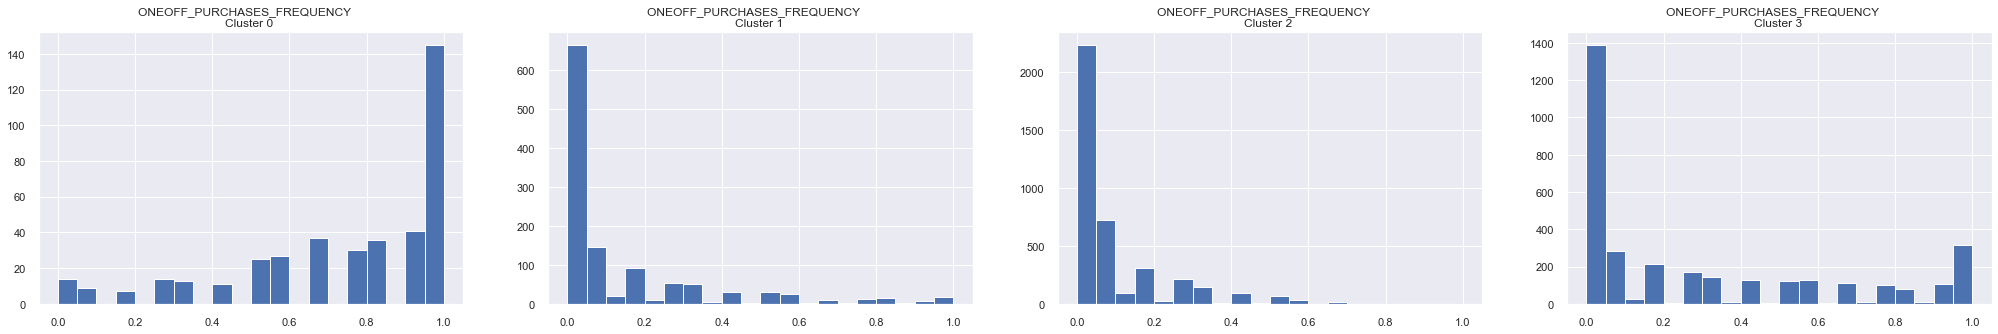

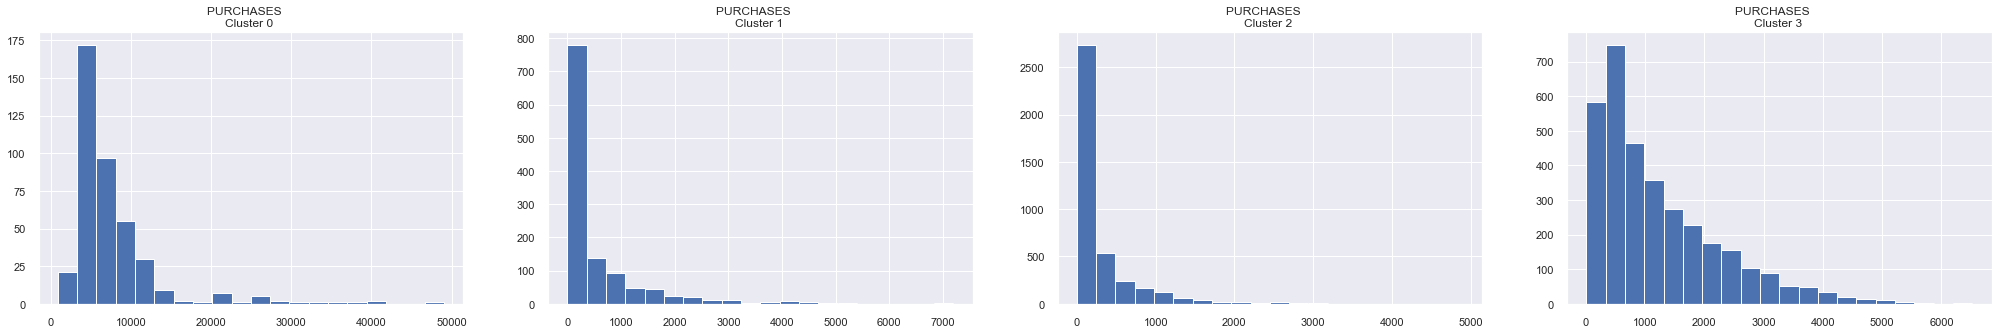

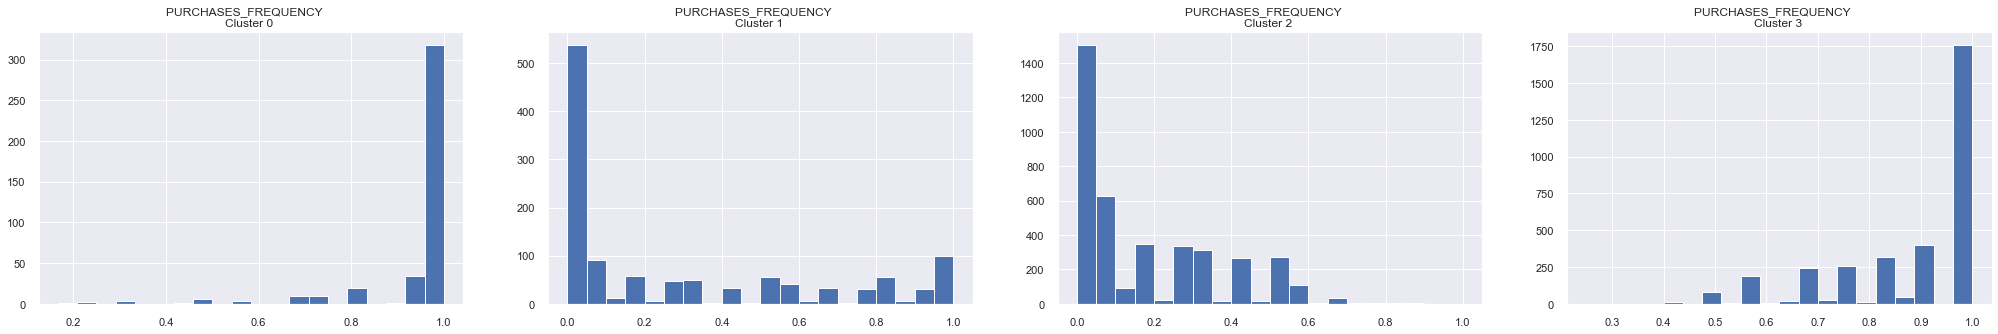

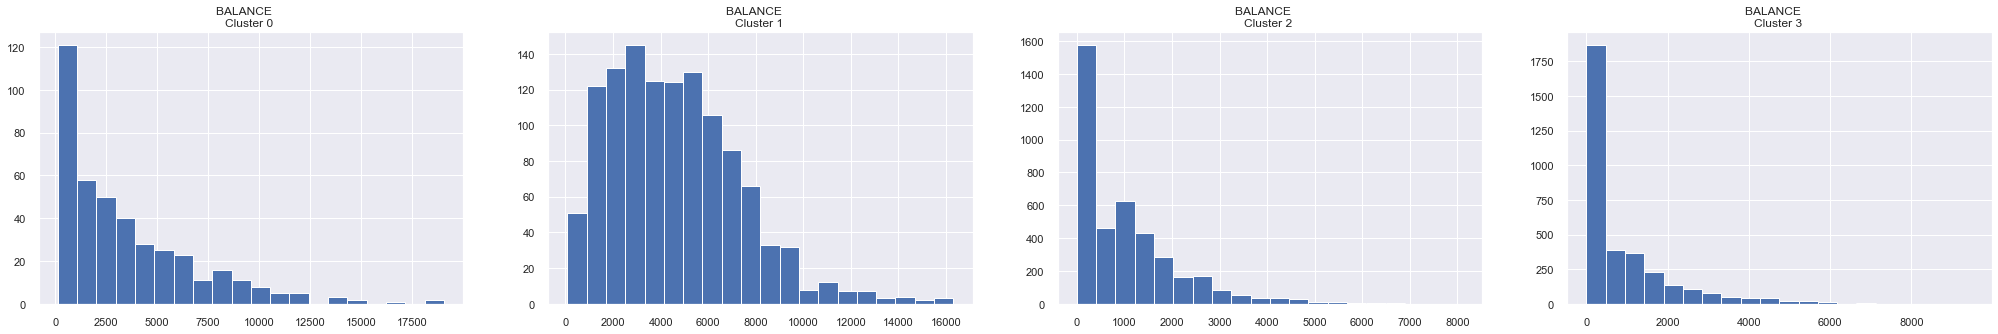

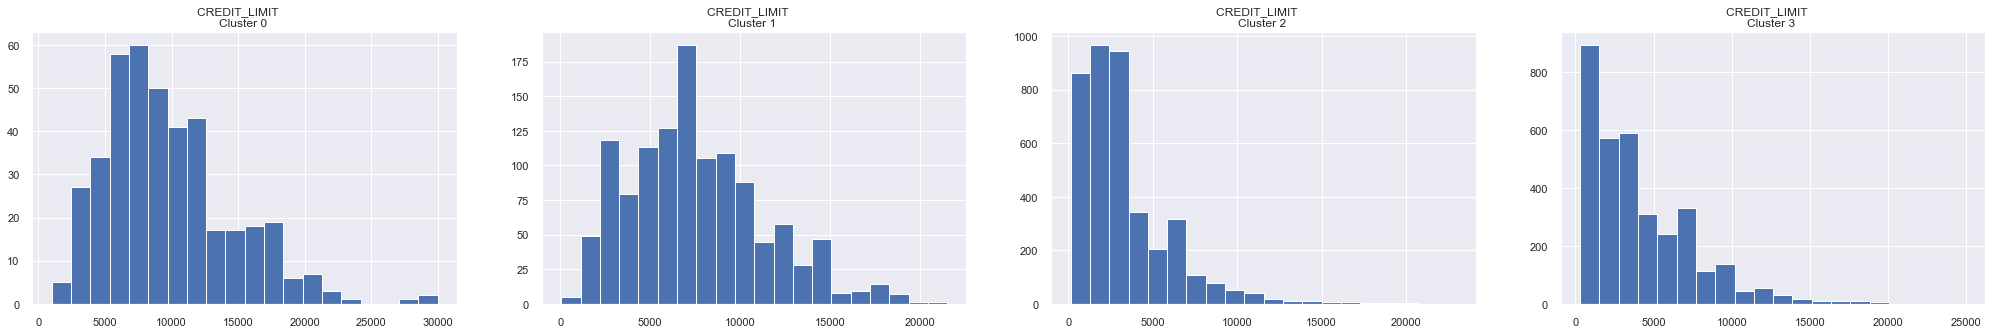

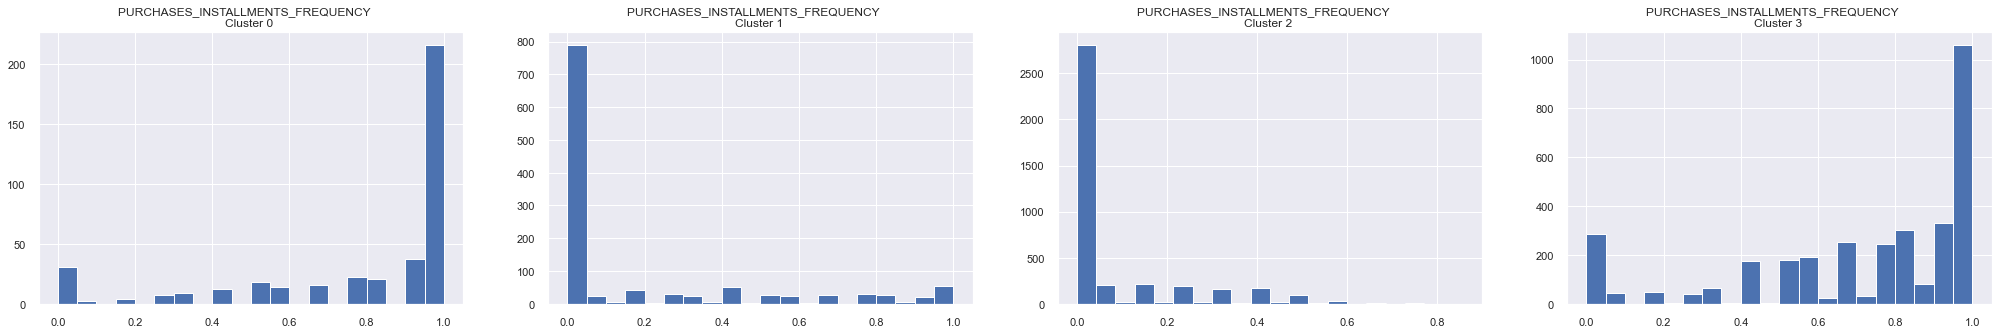

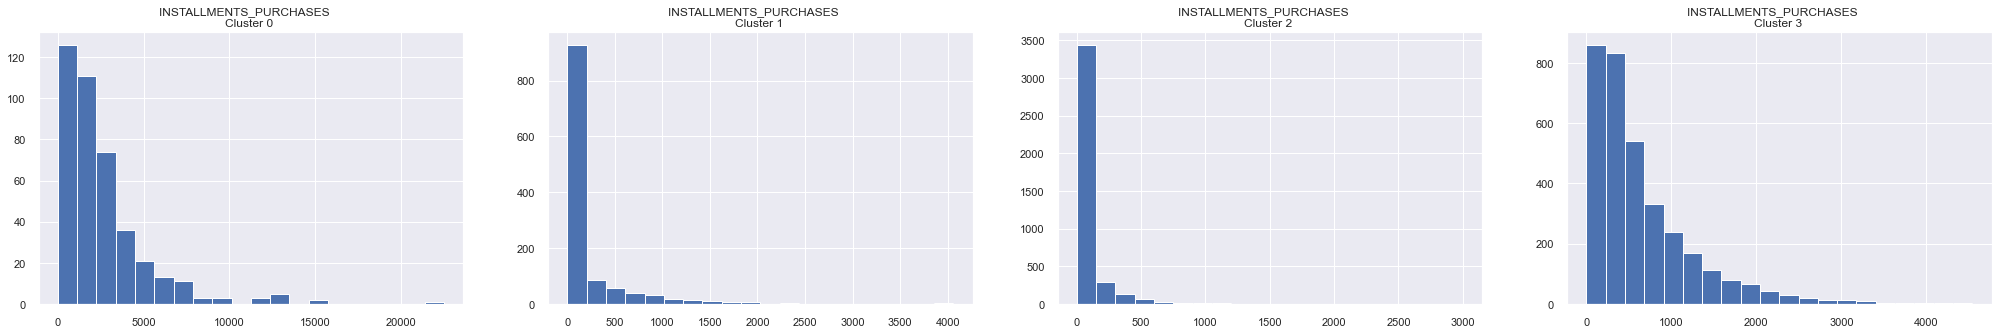

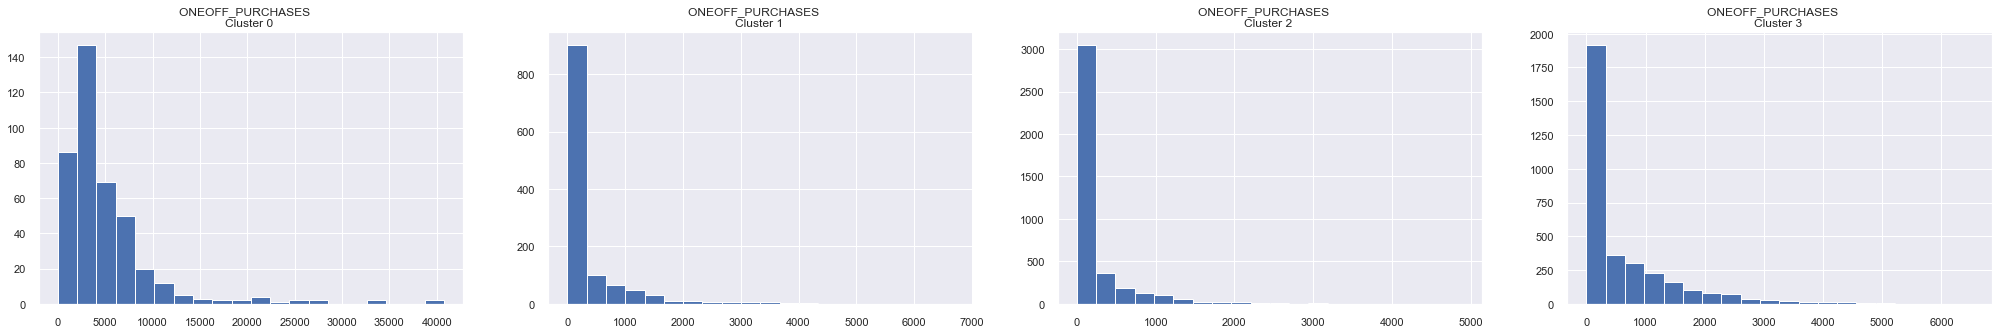

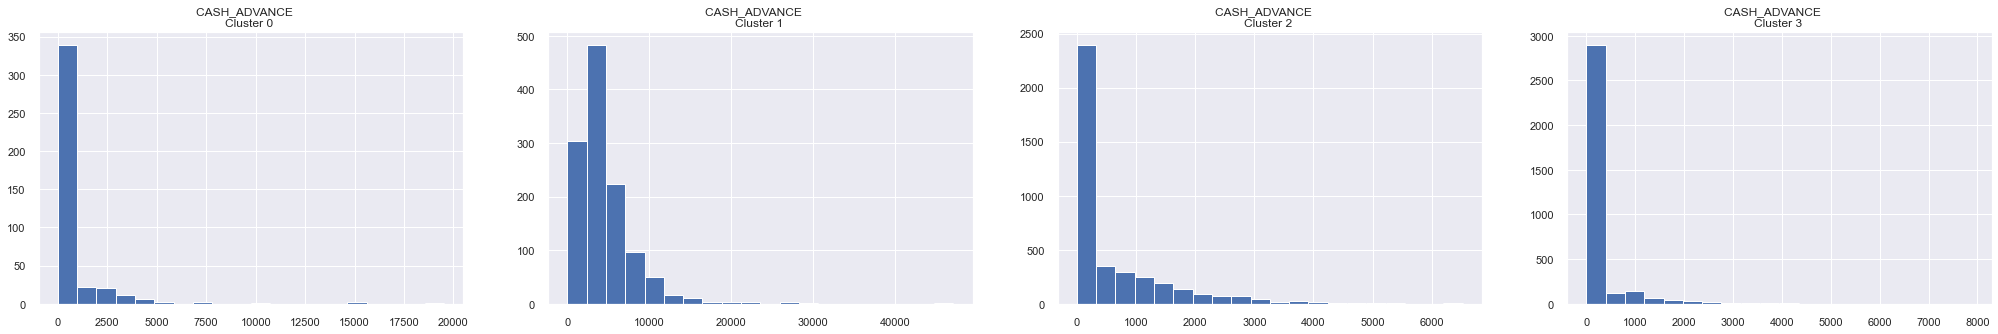

In [98]:
# Plot the histogram of various clusters
for i in transformed_df.columns:
    plt.figure(figsize=(35, 5))
    for j in range(4):
        plt.subplot(1, 4, j + 1)
        cluster = creditcard_df_cluster[creditcard_df_cluster["cluster"] == j]
        cluster[i].hist(bins=20)
        plt.title("{}    \nCluster {} ".format(i, j))

    plt.show()

### Practice exercise for you
- Try out different values for `n_clusters` in `KMeans` and examine the clusters. 
- If you are feeling adventurous, you may try customer segmentation on [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club). 

<br><br><br><br>

## Final comments and summary 

### A comment on initialization

- The initialization of K-Means is stochastic, can this affect the results?
    - Yes! Big time.  
- Let's  look at an example. 

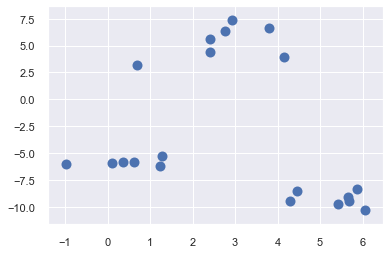

In [99]:
X, y = make_blobs(n_samples=20, centers=3, n_features=2, random_state=10)
mglearn.discrete_scatter(X[:, 0], X[:, 1], markers="o");

In [100]:
k = 3
n_examples = X.shape[0]
toy_df = pd.DataFrame(X, columns=["feat1", "feat2"])

### Example: Bad initialization 

In [101]:
np.random.seed(seed=10)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
centroids = X[centroids_idx]

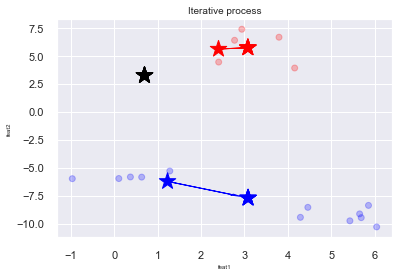

In [102]:
plot_iterative(toy_df, 6, 4, centroids)

### Example: Better initialization 
The following initialization seems much better. 

In [103]:
np.random.seed(seed=2)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
centroids = X[centroids_idx]

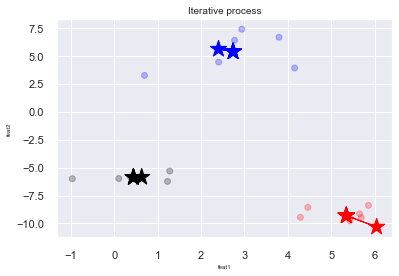

In [104]:
plot_iterative(toy_df, 6, 4, centroids)

### What can we do about it?

- One strategy is to run the algorithm several times. 
    - Check out `n_init` parameter of [`sklearn`'s `KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 
- Is it possible to pick `K` in a smart way? 
    - Yes! We can use the so-called [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).
    - Intuitively, it picks the initial centroids which are far away from each other. 
    - In other words, K-Means++ gives more chance to select points that are far away from centroids already picked.    
    - By default `sklearn` uses this strategy for initialization. 

### Important points to remember

- Clustering is a common unsupervised approach to identify underlying structure in data and grouping points based on similarity. 
- K-Means is a popular clustering algorithm. 

### Important points to remember

**K-Means**
- It requires us to specify the number of clusters in advance. 
- Each example is assigned to one (and only one) cluster.
- The labels provided by the algorithm have no actual meaning. 
- The centroids live in the same space as of the dataset but they are **not** actual data points, but instead are average points.
- It always converges. Convergence is dependent upon the initial centers and it may converge to a sub-optimal solution. 

### Important points to remember

- Two ways to provide insight into how many clusters are reasonable for the give problem are: **the Elbow method** and **the Silhouette method**.  
- Some applications of K-Means clustering include data exploration, feature engineering, customer segmentation, and document clustering. 
- It takes fair amount of manual effort and domain knowledge to interpret clusters returned by K-Means. 

## Resources 
- ["Spaghetti Sauce" talk by Malcom Gladwell](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en)
- [Visualizing-k-means-clustering](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) 
- [Visualizing K-Means algorithm with D3.js](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/)
- [Clustering with Scikit with GIFs](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)
- [`sklearn` clustering documentation](https://scikit-learn.org/stable/modules/clustering.html)

<br><br><br><br>

## Questions for class Discussion <a name="questions"></a>